In [34]:
import pyspark
from pyspark.sql import SparkSession
import seaborn as sns
import pandas as pd


# Initialize Spark session
spark = SparkSession.builder \
    .appName("MyApp") \
    .getOrCreate()

# Read CSV file into DataFrame
df = spark.read.csv("./archive/ecommerce_customer_data_large.csv", header=True, inferSchema=True)

# Show the DataFrame
df.show()

# Check for null values in the DataFrame
null_counts = df.select([pyspark.sql.functions.count(pyspark.sql.functions.when(pyspark.sql.functions.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

# Replace null values in the 'Returns' column with 0
df = df.fillna({'Returns': 0})

# Show the updated DataFrame
df.show()

# Check for null values in the DataFrame
null_counts = df.select([pyspark.sql.functions.count(pyspark.sql.functions.when(pyspark.sql.functions.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|Customer ID|      Purchase Date|Product Category|Product Price|Quantity|Total Purchase Amount|Payment Method|Customer Age|Returns| Customer Name|Age|Gender|Churn|
+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|      44605|2023-05-03 21:30:02|            Home|          177|       1|                 2427|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2021-05-16 13:57:44|     Electronics|          174|       3|                 2448|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2020-07-13 06:16:57|           Books|          413|       1|                 2345|   Credit Card|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|202

In [35]:
from pyspark.sql.functions import sum

# Calculate revenue for each customer
customer_revenue = df.groupBy("Customer ID").agg(sum("Total Purchase Amount").alias("Total Revenue"))

# Show the result
customer_revenue.show()

+-----------+-------------+
|Customer ID|Total Revenue|
+-----------+-------------+
|       7340|        13826|
|       8086|        23281|
|      36131|        16797|
|      31367|        16032|
|      43935|        11130|
|      14450|        26822|
|      30361|        11787|
|       3918|         9178|
|      32414|        11284|
|      33569|        18869|
|      46465|         4834|
|      25591|        12406|
|      24347|        19534|
|      19984|        37994|
|      35361|        10871|
|      28024|        14832|
|      41575|         8314|
|      31236|        10360|
|       9852|        11488|
|      36224|        11668|
+-----------+-------------+
only showing top 20 rows



In [36]:
# Show all unique product categories
df.select("Product Category").distinct().show()

+----------------+
|Product Category|
+----------------+
|            Home|
|     Electronics|
|        Clothing|
|           Books|
+----------------+



+----------------+-------------+
|Product Category|Total Revenue|
+----------------+-------------+
|            Home|    171138916|
|     Electronics|    170146025|
|        Clothing|    170716122|
|           Books|    169345236|
+----------------+-------------+



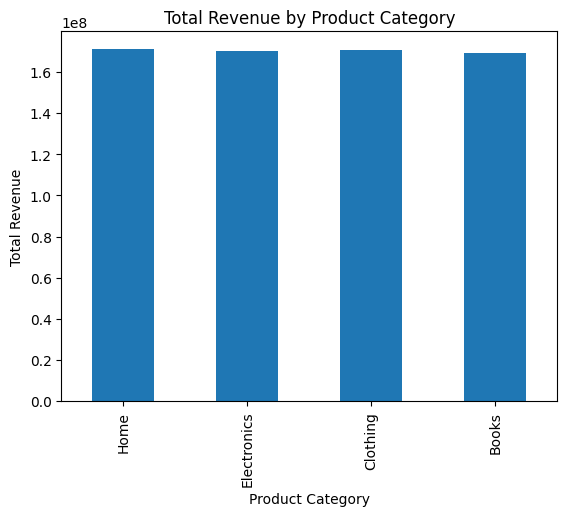

In [37]:
from pyspark.sql.functions import sum

# Calculate revenue for each product category
category_revenue = df.groupBy("Product Category").agg(sum("Total Purchase Amount").alias("Total Revenue"))

# Show the result
category_revenue.show()

import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for plotting
category_revenue_pd = category_revenue.toPandas()

# Plot the bar chart
category_revenue_pd.plot(x='Product Category', y='Total Revenue', kind='bar', legend=False)
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Product Category')
plt.show()

+----------------+----+-------------+
|Product Category|Year|Total Revenue|
+----------------+----+-------------+
|           Books|2020|     45740540|
|           Books|2021|     46173355|
|           Books|2022|     45772497|
|           Books|2023|     31658844|
|        Clothing|2020|     46587619|
|        Clothing|2021|     45598343|
|        Clothing|2022|     46428406|
|        Clothing|2023|     32101754|
|     Electronics|2020|     46155946|
|     Electronics|2021|     46113046|
|     Electronics|2022|     45921689|
|     Electronics|2023|     31955344|
|            Home|2020|     46393399|
|            Home|2021|     45787737|
|            Home|2022|     46222135|
|            Home|2023|     32735645|
+----------------+----+-------------+



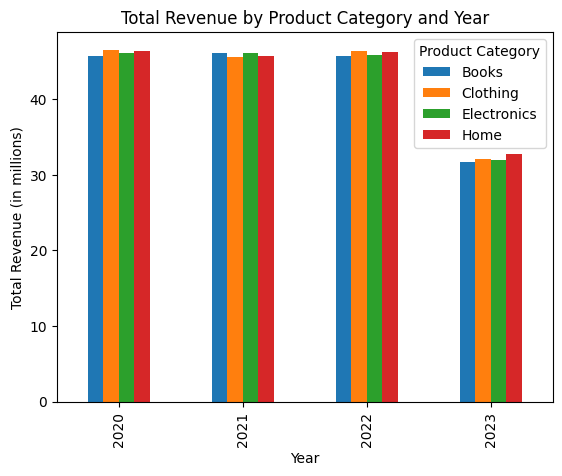

In [38]:
from pyspark.sql.functions import sum, year

# Extract year from Purchase Date and create a new column 'Year'
df = df.withColumn("Year", year(df["Purchase Date"]))

# Calculate revenue for each product category in every year
category_yearly_revenue = df.groupBy("Product Category", "Year").agg(sum("Total Purchase Amount").alias("Total Revenue")).sort("Product Category", "Year")

# Show the result
category_yearly_revenue.show()

import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for plotting
category_yearly_revenue_pd = category_yearly_revenue.toPandas()

# Convert Total Revenue to millions
category_yearly_revenue_pd['Total Revenue'] = category_yearly_revenue_pd['Total Revenue'] / 1000000

# Plot the bar chart
category_yearly_revenue_pd.pivot(index='Year', columns='Product Category', values='Total Revenue').plot(kind='bar', stacked=False, legend=True)
plt.xlabel('Year')
plt.ylabel('Total Revenue (in millions)')
plt.title('Total Revenue by Product Category and Year')
plt.show()


+----+-------+-------------+
|Year|Quarter|Total Revenue|
+----+-------+-------------+
|2020|      1|     45744832|
|2020|      2|     45641043|
|2020|      3|     46899933|
|2020|      4|     46591696|
|2021|      1|     45112173|
|2021|      2|     45657051|
|2021|      3|     46900393|
|2021|      4|     46002864|
|2022|      1|     45174813|
|2022|      2|     46299953|
|2022|      3|     46178450|
|2022|      4|     46691511|
|2023|      1|     45576239|
|2023|      2|     45439449|
|2023|      3|     37435899|
+----+-------+-------------+



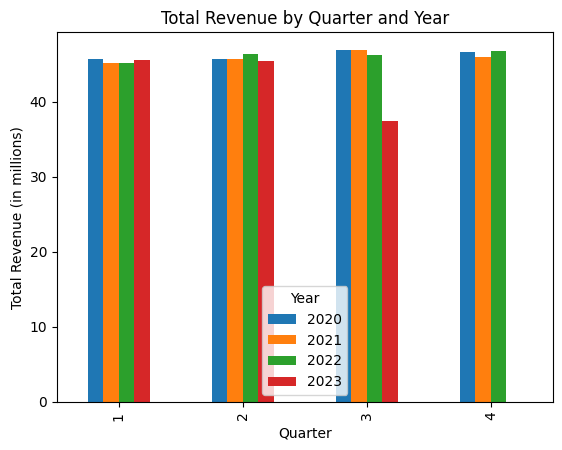

In [39]:
from pyspark.sql.functions import quarter

# Calculate revenue for every quarter
quarterly_revenue = df.groupBy("Year", quarter("Purchase Date").alias("Quarter")).agg(sum("Total Purchase Amount").alias("Total Revenue")).sort("Year", "Quarter")

# Show the result
quarterly_revenue.show()

# Convert to Pandas DataFrame for plotting
quarterly_revenue_pd = quarterly_revenue.toPandas()

# Convert Total Revenue to millions
quarterly_revenue_pd['Total Revenue'] = quarterly_revenue_pd['Total Revenue'] / 1000000

# Plot the bar chart and group quarters for each year
quarterly_revenue_pd.pivot(index='Quarter', columns='Year', values='Total Revenue').plot(kind='bar', stacked=False)
plt.xlabel('Quarter')
plt.ylabel('Total Revenue (in millions)')
plt.title('Total Revenue by Quarter and Year')
plt.legend(title='Year')
plt.show()


+------+-------------+
|Gender|Total Revenue|
+------+-------------+
|Female|    338559456|
|  Male|    342786843|
+------+-------------+



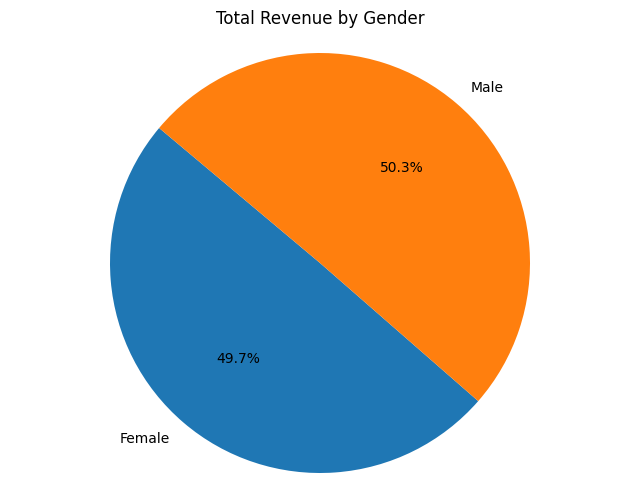

In [41]:
from pyspark.sql.functions import sum

# Calculate revenue for each gender
gender_revenue = df.groupBy("Gender").agg(sum("Total Purchase Amount").alias("Total Revenue"))

# Show the result
gender_revenue.show()

import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for plotting
gender_revenue_pd = gender_revenue.toPandas()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_revenue_pd['Total Revenue'], labels=gender_revenue_pd['Gender'], autopct='%1.1f%%', startangle=140)
plt.title('Total Revenue by Gender')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()